# part I

The dataset `training_dataset.fasta` has been downloaded from RFAM (https://rfam.xfam.org/), a large database of (non-coding) RNA sequences divided in families. In particular, the dataset includes most of the sequences of RF00162 family, that are SAM-riboswitches, a class of riboswitch that regulate gene expression in response to S-Adenosyl methionine (SAM) binding (see https://en.wikipedia.org/wiki/SAM_riboswitch_(S-box_leader) for more info).

In this tutorial, we will train several generative models with this dataset. To test the trained models, we will use another dataset, `test_dataset.fasta` which contains some other members of the RF00162 family, together with other (artificially generated) RNA sequences. The overall task is to use the trained models to distinguish between the original RFAM sequences and those generated artificially.

#### Task 1: collecting training sequences
Fasta formatted files (usual extensions for these files are .fasta, or .fa, or other which contains "fa") have a standar form: they can be divided in pairs of lines, of which the first starts with the symbol '>' and then there is some free text which is the label of the first sequence, and the second line is the sequence. 
The training dataset that we will use is in fasta format, and it is technically a multiple sequence alignment, that is the sequences contained in it share the same length and have been aligned in such a way that similar parts of the sequences have the same position. 
The first task for this part is to read the training dataset and obtain all the sequences contained in it. 

#### Task 2: compute conservations
Let us now give a look at the sequences. We can start from looking at each column of the multiple sequence alignment, and compute the conservation. As a first step, a good choice is to go from nucleotides to numbers, so that the list of sequences will become a rectangular matrix of integer numbers. Then, we can compute for each column $i$ the conservation $k_i$ , defined as:
$$ k_i = \log_2(q) - H(f_i) = \log_2(q) + \sum_n f_i(n) \log_2(f_i(n)) ,$$
where $q$ is the number of symbols allowed in the sequence and $f_i(n)$ is the frequency of symbol $n$ in position $i$.
Once we have computed the conservation for each position, we can plot them to visually see which parts of the sequneces are more conserved in our dataset.

#### [EXTRA] Task 3: check 2-point functions through mutual information
Conservations are about 1-point correlations, that is frequencies. However, we are also interested in higher order correlations. To have a general idea of whether there are pairs of positions which are correlated, we can use the mutual information, defined as
$$ MI_{ij} = \sum_{n,m} f_{ij}(n,m) \, \log\left(\frac{f_{ij}(n,m)}{f_i(n) f_j(m)}\right),  $$
where $f_{ij}(n,m)$ is the empirical probability of having the symbol $n$ in position $i$ and the symbol $m$ in position $j$. We can plot the resulting matrix through a color scale, and try to interpret the result.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def seq2num(seq):
    """Transform a sequence or list of sequences
    (seq) into a list of numbers."""
    AAs = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    ntdict = {AAs[k]:k for k in range(len(AAs))}
    if type(seq) == str:
        return np.array([ntdict[x] for x in seq], dtype=np.int16)[np.newaxis,:]
    elif type(seq) == list:
        return np.array([[ntdict[x] for x in seq_] for seq_ in seq], dtype=np.int16)
    
def frequencies(MSA2num, q):
    """Compute the frequency in each column of the MSA
    MSA2num provided, q being the size of the alphabet."""
    B = MSA2num.shape[0]
    N = MSA2num.shape[1]
    out = np.full((N, q), 0, dtype=np.float32)
    for i in range(q):
        out.T[i] += np.sum(MSA2num == i, axis=0)
    out /= B
    return out

def conservation(freqs, q):
    """Return the conservation, measured in bits."""
    conss = []
    for f in freqs:
        ff = f[f != 0]
        conss.append(np.log2(q) + np.sum(ff * np.log2(ff)))
    return conss


def read_fasta(file):
    "Read fasta file, returning (descriptors, sequences)."
    seqs = []
    labels = []
    with open(file, 'r') as f:
        lines = f.readlines()
        t_s = ""
        for l in lines:
            t_l = l.rstrip() # remove \n
            if t_l[0] == '>':
                if len(t_s) > 0:
                    seqs.append(t_s)   
                labels.append(t_l[1:])
                t_s = ""
            else:
                t_s = t_s + t_l
        seqs.append(t_s)    
    return labels, seqs
    
    

In [3]:
# load training dataset
train_labels, train_seqs = read_fasta('data/chorismate_alignment.faa')

In [4]:
# compute frequencies, conservations
q = 21
fs = frequencies(seq2num(train_seqs), q)
cs = conservation(fs, q)

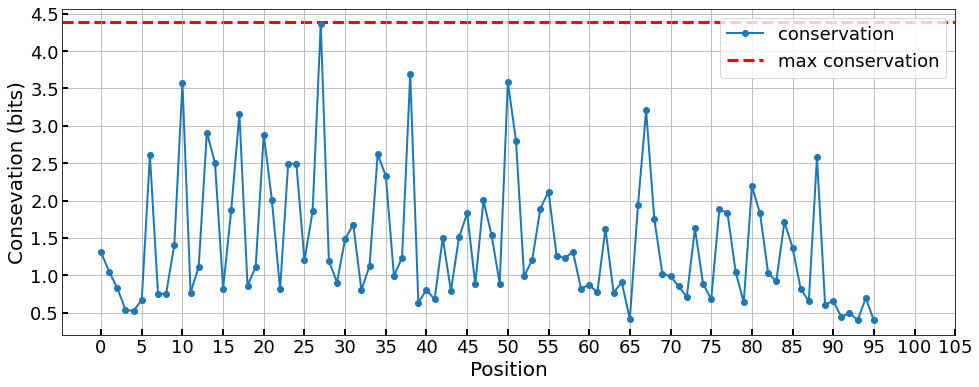

In [5]:
# plot conservations
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot()
ax.plot(cs, '-o', lw=2, color="C0", label="conservation")
ax.axhline(y=np.log2(21), color='r', lw=3, ls='dashed', label="max conservation", zorder=-1)
ax.legend(fontsize=18, loc=0, framealpha=0.8)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xticks([i*5 for i in range(22)])
ax.set_xlabel("Position", fontsize=20)
ax.set_ylabel("Consevation (bits)", fontsize=20)
ax.grid()

# part II


We will now use our discrimination task to check the performance of an independent site model of the form
$$ p(s) = \frac{1}{Z} e^{-E(s)}, \quad E(s) = - \sum_i h_i(s_i), $$
where $p(s)$ is the probability of the sequence $s$ according to the model, $h_i$ are the "local fields", that is the parameters to be inferred, and $s_i$ is the symbol (or integer number) present in position $i$ of the sequence $s$. $Z$ is a normalization.

The inference procedure can be greatly simplified by choosing the right gauge. Indeed, the transformation
$$ h_i(s_i) \to \tilde{h}_i(s_i) = h_i(s_i) + K_i $$
leaves the probabilities invariant.
We can then choose the gauge so that
$$ \sum_n e^{h_i(n)}=1 $$
for each position $i$, which immediately gives $Z=1$.
It is easy to check, in that case, that the log-likelihood of the observed data is maximized for the following choice of local fields:
$$ h_i(n) = \log(f_i(n)). $$

Notice, however, that there are some positions where some symbols are never observed. In principle, this would give an unrealistic minus-infinity local field, that we want to avoid. For this reason, we add a regularization in the form of a pseudo-count as follows. Consider that, to our dataset of size $M$, we add a purely random dataset of size $\alpha/(1-\alpha)$. The new frequencies becomes (can you prove it?):
$$ f_i(n) \to \tilde{f}_i(n) = (1-\alpha) f_i(n) + \frac{\alpha}{q}  $$

#### Task 4: fitting an independent-site model
* Find the fields of a independent-site model, and use $\alpha=0.5$ to regularize through the introduction of pseudo-counts.
* Read the test dataset, and notice that in the label there is written the origin of the sequence (RFAM or not).
* Use the independent-site model to compute the energy of each test sequence, and check whether the independent-site model model can discriminate those coming from RFAM from the others. Use the AUROC as a quantification of the performance (see the `metrics` package from `sklearn`).

#### [EXTRA] Task 5: sampling from independent-site model
The model we just fit can be used to generated new sequences. Indeed, it is enough to sample from the probability distribution that the model defines. Try to write a function to generate new sequences from this model. Which properties do you expect these sequences to have (with respect to those we discussed in the first part)?

In [6]:
#import pandas as pd
from sklearn import metrics

In [7]:
def indip_model_fields(freqs, alpha=0):
    """Fit the independent site model in the Z=1 gauge.
    Add pseudocounts, equivalent to a dataset fraction 
    alpha/(1-alpha) of random sequences added to the dataset."""
    q = freqs.shape[1]
    pc_freqs = freqs * (1 - alpha) + alpha / q
    return np.log(pc_freqs)


def energy_indip_model(fields, seqs):
    """Compute the energy of the sequences seqs according to the indepentend site model."""
    return -(fields[np.arange(len(fields)), seqs].sum(axis=1))


def sample_data_indip(fields, beta=1):
    """Generate new data by sampling the independent site model."""
    freqs = np.exp(beta * fields)
    q = np.arange(freqs.shape[1])
    new_data = np.array([np.random.choice(q, p = f/np.sum(f)) for f in freqs], dtype = np.int16)
    return new_data

def num2seq(num):
    "Inverse of seq2num."
    AAs = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    return ''.join([AAs[x] for x in num])

In [8]:
# "train" model
ind_model_fields = indip_model_fields(fs, alpha=0.1)

In [9]:
# load test set
_, test_seqs_pos = read_fasta("./data/functional_seqs.faa")
_, test_seqs_neg = read_fasta("./data/nonfunctional_seqs.faa")

In [10]:
# compute energies test sets
t_ss = seq2num(list(test_seqs_pos))
pos_en_ind = energy_indip_model(ind_model_fields, t_ss)
t_ss = seq2num(list(test_seqs_neg))
neg_en_ind = energy_indip_model(ind_model_fields, t_ss)

t_ss = seq2num(list(train_seqs))
train_en_ind = energy_indip_model(ind_model_fields, t_ss)

AUROC (pos vs neg): 0.7336817394425257


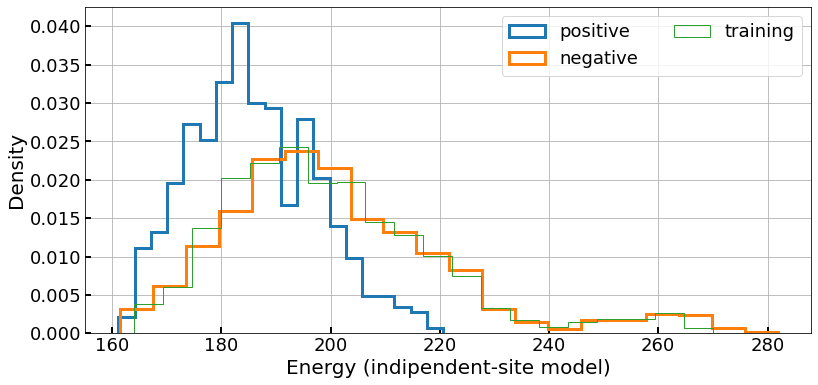

In [11]:
# plot histogram
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
ax.hist(pos_en_ind, histtype='step', fill=False, density=True, bins=20, lw=3, color="C0", label="positive")
ax.hist(neg_en_ind, histtype='step', fill=False, density=True, bins=20, lw=3, color="C1", label="negative")
ax.hist(train_en_ind, histtype='step', fill=False, density=True, bins=20, lw=1, color="C2", label="training")

ax.legend(fontsize=18, loc=0, framealpha=0.8, ncol=2)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Energy (indipendent-site model)", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.grid()
# compute AUROC test set (global)
scores_positives_val = -pos_en_ind
scores_negatives_val = -neg_en_ind
labels = np.hstack((np.zeros((len(scores_negatives_val))), np.ones((len(scores_positives_val))))) 
scores = np.hstack((scores_negatives_val, scores_positives_val))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)    
auroc_global = metrics.auc(fpr, tpr)
print("AUROC (pos vs neg):", auroc_global)

# part III

Now we turn to models able to capture 2-point correlations. We consider the model (Boltzmann Machine):
$$ p(x) = \frac{1}{Z} e^{-E(s)}, \quad E(s) = \sum_{i, a, j, b} s_{i}(a) \, J_{i,j}(a,b) \, s_{j}(b) + \sum_{i, a} \, h_i(a) s_i(a), $$
where $s_{i}(a)$ is a categorical (1-hot) variable which is 1 if the symbol $a$ is present in position $i$ in the sequence $s$, 0 otherwise.
In this case the exact inference of the model (that is, the problem of maximizing the log-likelihood of the data) cannot be solved exactly. We will consider here the Gaussian approximation, which allows the problem to be solved easily provided that the categorical variables have zero average. To do that, we consider the new model:
$$ p(x) = \frac{1}{Z} e^{-E(\tilde{s})}, \quad E(\tilde{s}) = \sum_{i, a, j, b} \tilde{s}_{i}(a) \, J_{i,j}(a,b) \, \tilde{s}_{j}(b) + \sum_{i, a} \, h_i(a) \tilde{s}_i(a), $$
where $\tilde{s}_i(a) = s_i - f_i(a)$. Notice that, once we know how to infer the parameters for this new model, the old one can be immediately recovered by inserting the expression for the variables $\tilde{s}_i(a)$.
The Gaussian approximation consists in neglecting the binary nature of the categorical variables, and in computing the parameters $J_{i,j}(a,b)$ and $h_i(a)$ as if they were continuous variables. The relevant advantage in this case is that the normalization $Z$ can be computed exactly and derived with respect to the parameters during the maximization of the log-likelihood, and the solution is:
$$ h_i(a) = 0, \quad J_{i,j}(a,b) = - \tilde{C}^{-1}_{ia, jb}, $$
where $C^{-1}_{ia, jb}$ is the inverse of the correlation matrix of the (shifted) categorical variables, that is
$$ \tilde{C}_{ia, jb} = \frac{1}{M} \sum_s \tilde{s}_i(a) \tilde{s}_j(b), $$
where $M$ is the number of sequences in the training dataset and the sum spans the sequences of the training dataset. Notice that this correlation matrix can be written as
$$ \tilde{C}_{ia, jb} = \frac{1}{M} \sum_s s_i(a) s_j(b) - f_i(a) f_j(b) = C_{ia, jb} - f_i(a) f_j(b), $$
where $C_{ia, jb}$ is the correlation matrix of the original variables.

Unfortunately, the correlation matrix as it is cannot be inverted. There are two reasons for that, that need to be addressed with two, separated considerations. Firstly, as in the indipendent-site case, a choice of gauge must be made to remove $L$ null eigenvalues from the correlation matrix. The easiest one in this case is to just neglect one of the symbols in each site. With a slight simplification, one can understand this because for each position $i$, even if there are $q$ symbols, only $q-1$ categorical variables are needed: if each of them is zero, it means that in position $i$ there is the only symbol for which we are not keeping the categorical variable.
Even after the gauge fixing, the correlation matrix can still be not invertible. This happens when the number of data is low (lower than the lenght of each the sequence in categorical variables after gauge fixing) or if the data are correlated. In this case, we need again to rely on a regularization method to overcome the problem. We can again use pseudo-counts, transforming the frequences as we did for the indipendent-site model and the 2-point correlations as
$$ f_{ij}(a,b) \to \tilde{f}_{ij}(a,b) = (1-\alpha) f_{ij}(a,b) + \frac{\alpha}{q^2}. $$
Unfortunately, this time a little extra trick is needed to fix things up after this transformation. Indeed, this transformation has the unwanted properties that now $\tilde{f}_{ii}(a,b) \neq 0$ for $a \neq b$, and that $\tilde{f}_{ii}(a,a) \neq f_i(a)$. To get meaningful, reguralized frequencies and 2-point correlations, both of these properties must be re-imposed *a posteriori* after applying the transformation.

#### Task 6: fitting a Gaussian Boltzmann Machine
* Go from our dataset written in numerical variables to a dataset written in categorial, binary variables. At this point, fix the gauge by neglecting one symbol for each position.
* Compute the frequencies and the correlation matrix of these variables.
* Apply the transformations discussed to both these object, and modify the correlation matrix by removing the matrix
$ F_{ia, jb} = f_i(a) f_j(b) $ as discussed above.
* Invert the resulting matrix (you can use the function `numpy.linalg.inv` from numpy) to get the $J$ matrix of the model.
* Compute the energy of each sequence in the training set, and check whether the new model can discriminate those coming from RFAM from the others. Use the AUROC as a quantification of the performance (see the metrics package from sklearn). 

#### [EXTRA] Task 7: sampling from Gaussian Boltzmann Machine
As for the independent-site model, the Gaussian Boltzmann Machine model define a probability distribution over the sequences, and hence can be used to generate new sequences. However, this is much more difficult due to the fact that $Z$ cannot be computed easily (when the variables are back to their binary nature), and that it is not known how to sample directly from the quadratic model (again, when the variables are binary). To overcome this problem, try to write Metropolis routine and sample from the model. 

In [12]:
def seq2occurrence(seqs, q_true=21):
    """Expand the alignment in an array of binary
    occurrence variables. Moreover, fix the gauge 
    by removing the last symbol."""
    B = seqs.shape[0]
    N = seqs.shape[1]
    q_gauge = q_true-1
    msa_exp = np.zeros((B, N * q_gauge), dtype=np.int16)
    for i in range(N):
        for a in range(q_gauge):
            msa_exp[:,i*q_gauge+a] = (seqs[:,i] == a)
    return msa_exp


def compute_correlation_matrix(data_points):
    """Compute correlation matrix, provided that the
    data points are given as binary occurrence variables."""
    M = data_points.shape[0]
    x = data_points.astype(np.float32)
    xt = x.transpose()
    c = np.dot(xt, x) / M
    return c


def add_pseudocounts(corr_mat, freqs, alpha, q_true=5):
    """Add pseudocounts according to the 
    parameter alpha to the frequencies and the correlation matrix,
    and return them."""
    q_gauge = q_true - 1
    N = len(freqs) // q_gauge
    f_pseudo = (1-alpha)*freqs + alpha/q_true
    c_pseudo = (1-alpha)*corr_mat + alpha/(q_true**2)
    #Fix the conservation constraints in the diagonal blocks
    for i in range(N):
        c_pseudo[i*q_gauge:(i+1)*q_gauge,i*q_gauge:(i+1)*q_gauge] = 0
        for a in range(q_gauge):
            c_pseudo[i*q_gauge+a,i*q_gauge+a] = f_pseudo[i*q_gauge+a]
    return f_pseudo, c_pseudo


def connect_correlation(corr_mat, freqs):
    """Given the correlation matrix and the frequencies,
    return the connected correlation matrix."""
    c_connected = corr_mat - np.outer(freqs, freqs)
    return c_connected
    
    
def bm_energy(jcoupling_gauss, ave_freqs, seq):
    """Compute energy of seq with the BM model."""
    # collect local fileds
    h = np.dot(jcoupling_gauss, ave_freqs)
    ener1 = - np.dot(h, seq)
    ener2 = np.dot(seq, np.dot(jcoupling_gauss, seq)) / 2
    return -(ener1 + ener2)

def seq_from_1hot_gauged(seq1hot, q_true = 21):
    seq2num = []
    for i in range(len(seq1hot)//(q_true-1)):
        t_piece = seq1hot[i*(q_true-1):(i+1)*(q_true-1)]
        where = (t_piece == 1)
        if np.sum(where) == 0:
            seq2num.append(q_true-1)
        elif np.sum(where) == 1:
            seq2num.append(np.arange(q_true-1)[where][0])
        else:
            print("problem!")
    return num2seq(seq2num)

def metropolis(jcoupl, p, Nsteps, beta=1, q_true = 21, start_conf=np.nan):
    """Handle a single chain, starting in start_conf configuration, doing Nsteps steps 
    (each step is a single, random site flip)."""
    L = len(p)
    # prepare initial config
    if np.isnan(np.sum(start_conf)):
        s = np.random.randint(1, size=L)
        start_conf = s.copy()
    else:
        if type(start_conf[0]) != np.int32:
            print('Please use starting configuration in numeric form or use None for random start.')
            return 1
        else:
            s = start_conf
    # metropolis
    for k in range(0, Nsteps):
        # propose move
        pos_t = np.random.randint(len(p)//(q_true-1))
        t_n = np.random.randint(q_true)
        t_1hot = np.repeat(0, q_true-1)
        if t_n == q_true-1:
            pass
        else:
            t_1hot[t_n] = 1
        s_t = s.copy()
        s_t[pos_t*(q_true-1):(pos_t+1)*(q_true-1)] = t_1hot
        # accept or not
        
      #  h = np.dot(jcoupling_gauss, ave_freqs)
    #ener1 = - np.dot(h, seq)
    #ener2 = np.dot(seq, np.dot(jcoupling_gauss, seq)) / 2
    #return -(ener1 + ener2)
        
        h = np.dot(jcoupl[pos_t*(q_true-1):(pos_t+1)*(q_true-1)] , p)
        delta_h = - np.dot( (s-s_t)[pos_t*(q_true-1):(pos_t+1)*(q_true-1)], h )
        jcoupl_diag = jcoupl[pos_t*(q_true-1):(pos_t+1)*(q_true-1),pos_t*(q_true-1):(pos_t+1)*(q_true-1)]
        jcoupl_marginal = np.dot( jcoupl[pos_t*(q_true-1):(pos_t+1)*(q_true-1)] , s)
        delta_seq = (s-s_t)[pos_t*(q_true-1):(pos_t+1)*(q_true-1)]
        delta_coupl1 = np.dot( delta_seq , jcoupl_marginal  )
        delta_coupl2 = - 0.5 * np.dot( delta_seq, np.dot(jcoupl_diag, delta_seq)  )
        energy_diff = delta_h + delta_coupl1 + delta_coupl2
        #energy_diff = bm_energy(jcoupl, p, s_t) - bm_energy(jcoupl, p, s)
        prob = min(1, np.exp(- beta * (energy_diff)))
        x = np.random.rand()
        if x < prob:
            s = s_t.copy()
    return s

In [13]:
# prepare sequences in binary occurrence variables
train_2num = seq2num(train_seqs)
train_occurrence = seq2occurrence(train_2num, q_true=21)

# compute (non connected) correlation matrix
c = compute_correlation_matrix(train_occurrence)

# add pseudocount and take connected matrix
M = train_occurrence.shape[0]
freqs = np.sum(train_occurrence, axis=0) / M
f_reg, c_reg = add_pseudocounts(c, freqs, alpha=0.2, q_true=21)
c_reg_connected = connect_correlation(c_reg, f_reg)

# compute coupling matrix
jcoupl=-np.linalg.inv(c_reg_connected)

In [14]:
# compute energies test sets
t_ss = seq2occurrence(seq2num(list(test_seqs_pos)), q_true=21)
pos_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])
t_ss = seq2occurrence(seq2num(list(test_seqs_neg)), q_true=21)
neg_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])

t_ss = seq2occurrence(seq2num(list(train_seqs)), q_true=21)
train_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])

AUROC (RFAM vs generated): 0.8034172852889365


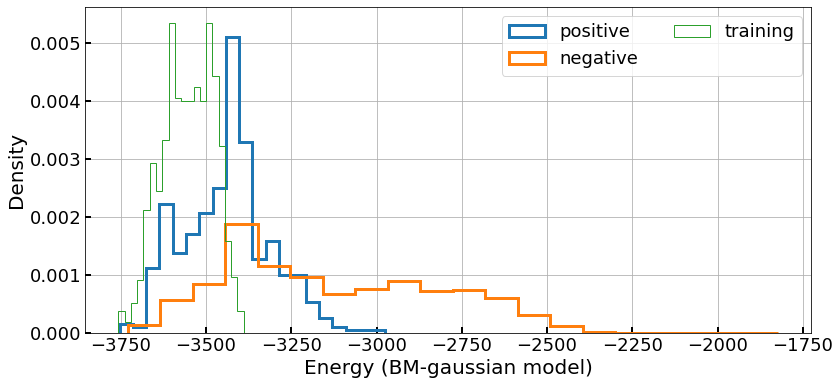

In [15]:
# plot histogram
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
ax.hist(pos_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C0", label="positive")
ax.hist(neg_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C1", label="negative")

ax.hist(train_en_bm, histtype='step', fill=False, density=True, bins=20, lw=1, color="C2", label="training")
ax.legend(fontsize=18, loc=0, framealpha=0.8, ncol=2)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Energy (BM-gaussian model)", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.grid()
# compute AUROC test set (global)
scores_positives_val = -pos_en_bm
scores_negatives_val = -neg_en_bm
labels = np.hstack((np.zeros((len(scores_negatives_val))), np.ones((len(scores_positives_val))))) 
scores = np.hstack((scores_negatives_val, scores_positives_val))
fpr, tpr, thresholds = metrics.roc_curve(labels, scores)    
auroc_global = metrics.auc(fpr, tpr)
print("AUROC (RFAM vs generated):", auroc_global)

In [78]:
# test sampling below

In [47]:
%time metropolis(jcoupl, freqs, 10, beta=3)

CPU times: user 13.3 ms, sys: 4.02 ms, total: 17.3 ms
Wall time: 4.3 ms


array([0, 0, 0, ..., 0, 0, 0])

In [110]:
from tqdm import tqdm
t_ss = seq2occurrence(seq2num(list(train_seqs)), q_true=21)
sample100 = np.array([metropolis(jcoupl, f_reg, 10000, beta=1, start_conf=t_ss[np.random.randint(len(t_ss))].astype('int32')) for _ in tqdm(range(100))])



  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:52,  1.88it/s]

  2%|▏         | 2/100 [00:01<00:53,  1.84it/s]

  3%|▎         | 3/100 [00:01<00:55,  1.74it/s]

  4%|▍         | 4/100 [00:02<00:55,  1.72it/s]

  5%|▌         | 5/100 [00:02<00:54,  1.74it/s]

  6%|▌         | 6/100 [00:03<00:56,  1.68it/s]

  7%|▋         | 7/100 [00:04<00:55,  1.67it/s]

  8%|▊         | 8/100 [00:04<00:55,  1.64it/s]

  9%|▉         | 9/100 [00:05<00:56,  1.60it/s]

 10%|█         | 10/100 [00:06<00:55,  1.62it/s]

 11%|█         | 11/100 [00:06<00:52,  1.69it/s]

 12%|█▏        | 12/100 [00:07<00:52,  1.69it/s]

 13%|█▎        | 13/100 [00:07<00:50,  1.73it/s]

 14%|█▍        | 14/100 [00:08<00:48,  1.79it/s]

 15%|█▌        | 15/100 [00:08<00:47,  1.77it/s]

 16%|█▌        | 16/100 [00:09<00:46,  1.80it/s]

 17%|█▋        | 17/100 [00:09<00:47,  1.74it/s]

 18%|█▊        | 18/100 [00:10<00:46,  1.77it/s]

 19%|█▉        | 19/100 [00:11<00:44,  1.81it/s]

 20%|██        |

In [111]:
seq_sample100 = [seq_from_1hot_gauged(x) for x in sample100]

In [24]:
seq_sample100

['-T-EKRTKEYRKQIDEIDKQMISMLNEKMELIDKVIAYKKENDLPAYLTSVYKQLLATLVDKLPQLNP-YADLKKQYWALVVMEAYNRVAEKINSG',
 'ATNEASINDLQARAQAVNDQAAELVEA-TNCSSKISKAQISNNSKVYVAKQEEAILRKISAEAKAYA-VPDEAVAAIYSEILQYAKNLPYQERS--',
 'PM-EESRLALAQEQEVITAEPVDLLSQVFRLTDEVAAYKQAHNLPAYDAEQDDQLMEALKEQSTRPEQVYDDYSETYLTDIINANKVIQRKYIEAY',
 'EQAQLKIKAIREELDALNDTIVSLLEQLLRIIEKAVAFKIEHGKSIADRQRVQEMLDRMLQYATASHPFNNDTIKNVYRQIASIAEKHVESQLEKK',
 '-AVDEAIKVVRDKISQLDQALIAIINERAGYALEPAGYGKKNHIPIYDPGQIRKFIRARLDQLEEYGNLPKDSLERIFERTIDEYERLEYKLIADH',
 'PDAVVSIEAYAAKLAEINAALLKAMGKRSRFMQDIAAYQSANQLPIYEADIDAQFLKAAKKQAKALK-IDSEFIEDIYALVRDVNIRIERQAFAQG',
 'ENAENTLEKLHDEISAVDDKVAAILQQRAEFAAQVASIQKEQHLAIYDPKQEAQILESVTSEDQKPGNYNAAVAKNFFKDIFKATRNYEEEERKDK',
 'EA-SEEFLSVTKQVDEIAEKFVDLVSRRNDHIKEARRYKKSHVIEFFQPDFEKEFVQKITKQSVAKGHYKPDLVKRIFQDLIDNCLEIYEEYKKNR',
 'TIQS-DIAKIREKIAEQNAATAATVEE-GRYSTEIGQYDERHQMPIYQRAREQSVIENIAKHAINNGP-YPETIKTFMNAMFTEAKRYQHRNLDTA',
 'VSVTTTMDELRAEADAIDDAVVALVGEVMYLIDRAGVVDRKNNSDATVEQVIKEMIAKAVEELVNKKQFYEKLIEQVYTQLVKHNIRLK

In [112]:
t_ss = seq2occurrence(seq2num(list(seq_sample100)), q_true=21)
sample_en_bm = np.array([bm_energy(jcoupl, f_reg, s) for s in t_ss])

In [113]:
len(seq_sample100[1])*20

1920

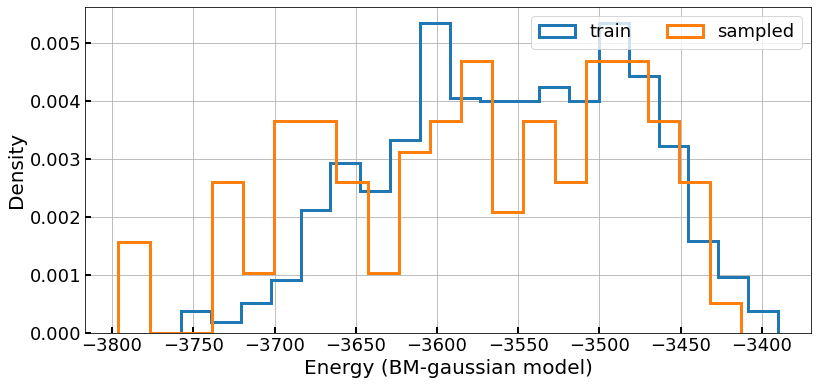

In [114]:
# plot histogram
fig = plt.figure(figsize=(13,6))
ax = fig.add_subplot()
ax.hist(train_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C0", label="train")
ax.hist(sample_en_bm, histtype='step', fill=False, density=True, bins=20, lw=3, color="C1", label="sampled")

ax.legend(fontsize=18, loc=0, framealpha=0.8, ncol=2)
ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Energy (BM-gaussian model)", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.grid()

In [63]:
sample_indip = np.array([sample_data_indip(ind_model_fields, beta=1) for _ in range(10000)])
sample_indip_occur = seq2occurrence(sample_indip)
print(sample_indip_occur.shape,train_occurrence.shape)

(10000, 1920) (1130, 1920)


In [115]:
def flatten_correlation_matrix(corr,q=21):
    L = int(corr.shape[0] / (q-1))
    flatten = []
    for i in range(L):
        for a in range(q-1):
            flatten = np.r_[flatten,corr[i*(q-1)+a,(i+1)*(q-1):]]
    return flatten
    

In [116]:
corr_train = compute_correlation_matrix(train_occurrence)
freqs_train = np.sum(train_occurrence, axis=0) / train_occurrence.shape[0]
corr_train_connect = connect_correlation(corr_train,freqs_train)

corr_sample = compute_correlation_matrix(sample100)
freqs_sample = np.sum(sample100, axis=0) / sample100.shape[0]
corr_sample_connect = connect_correlation(corr_sample,freqs_sample)

corr_indip = compute_correlation_matrix(sample_indip_occur)
freqs_indip = np.sum(sample_indip_occur, axis=0) / sample_indip_occur.shape[0]
corr_indip_connect = connect_correlation(corr_indip,freqs_indip)

(-0.1, 1.1)

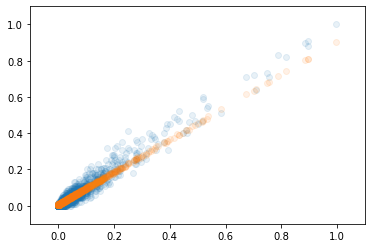

In [121]:
plt.scatter(freqs_train,freqs_sample,alpha=0.1)
plt.scatter(freqs_train,freqs_indip ,alpha=0.1)
plt.plot([-1,2],[-1,2],'r--',)
plt.ylim(-0.1,1.1)
plt.xlim(-0.1,1.1)

(-0.2, 0.2)

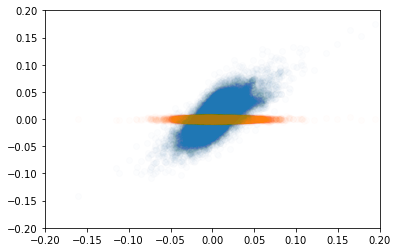

In [118]:
plt.scatter(flatten_correlation_matrix(corr_train_connect,q=21),flatten_correlation_matrix(corr_sample_connect,q=21), alpha=0.01)
plt.scatter(flatten_correlation_matrix(corr_train_connect,q=21),flatten_correlation_matrix(corr_indip_connect,q=21), alpha=0.01)
plt.ylim(-0.2,0.2)
plt.xlim(-0.2,0.2)

In [119]:
!jt -t oceans16